In [2]:
# Import necessary libraries
import os
# Import necessary libraries
import torch
# Import necessary libraries
import torchvision
# Import necessary libraries
import albumentations as A
# Import necessary libraries
import numpy as np
# Import necessary libraries
import cv2
# DataLoader is used to load data in batches for training
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
# Import necessary libraries
import matplotlib.pyplot as plt


In [3]:
cityscapes_image_pairs_path= "/content/drive/My Drive/Colab_Notebooks/Cityscape transformer model/cityscapes_data"
# Training loop starts here
train_dir = os.path.join(cityscapes_image_pairs_path, "/content/drive/My Drive/Colab_Notebooks/Cityscape transformer model/cityscapes_data/train")
val_dir = os.path.join(cityscapes_image_pairs_path, "/content/drive/My Drive/Colab_Notebooks/Cityscape transformer model/cityscapes_data/val")

print(f"Train Directory: {train_dir}")
print(f"Val Directory: {val_dir}")

Train Directory: /content/drive/My Drive/Colab_Notebooks/Cityscape transformer model/cityscapes_data/train
Val Directory: /content/drive/My Drive/Colab_Notebooks/Cityscape transformer model/cityscapes_data/val


In [4]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# Load SegFormer Processor and Model
# Training loop starts here
processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
# Initialize the segmentation model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.to("cuda")  # Move model to GPU if available

print("SegFormer Model Loaded Successfully!")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

SegFormer Model Loaded Successfully!


In [5]:
# Import necessary libraries
import torch
# Import necessary libraries
import albumentations as A
# Import necessary libraries
import cv2
# DataLoader is used to load data in batches for training
from torch.utils.data import Dataset, DataLoader
# Import necessary libraries
import numpy as np

class CityscapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, processor=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.processor = processor

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])  # Assuming masks have the same filename

        # Load Image & Mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.array(mask, dtype=np.uint8)  # Ensure NumPy format

        # 🚀 Fix: Ensure masks are within valid range [0, 18]
        mask[mask >= 19] = 18

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        mask = torch.tensor(mask, dtype=torch.long)  # Convert back to tensor

        if self.processor:
            inputs = self.processor(image, return_tensors="pt")
            image = inputs['pixel_values'].squeeze(0)

        return image, mask


In [6]:
# Define Augmentations
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

# Load Datasets
# Training loop starts here
train_dataset = CityscapesDataset(train_dir, train_dir, transform=transform, processor=processor)
val_dataset = CityscapesDataset(val_dir, val_dir, transform=None, processor=processor)

# DataLoader is used to load data in batches for training
# Define DataLoaders
batch_size = 4
# DataLoader is used to load data in batches for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# DataLoader is used to load data in batches for training
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




In [9]:
# Import necessary libraries
import torch.optim as optim
# Import necessary libraries
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function for training
criterion = torch.nn.CrossEntropyLoss()
# Define the optimizer to update model weights
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

num_epochs = 20  # You can increase this

# Loop over the number of training epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

# DataLoader is used to load data in batches for training
    for images, masks in train_loader:  # Assuming DataLoader is set up
        images, masks = images.to(device), masks.to(device)

# Define the optimizer to update model weights
        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

# Define the loss function for training
        loss = criterion(outputs, masks)
        loss.backward()
# Define the optimizer to update model weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")


Epoch 1/20, Loss: 1852.3989
Epoch 2/20, Loss: 420.3938
Epoch 3/20, Loss: 266.2129
Epoch 4/20, Loss: 195.7649
Epoch 5/20, Loss: 160.1891
Epoch 6/20, Loss: 141.0774
Epoch 7/20, Loss: 124.2592
Epoch 8/20, Loss: 114.2551
Epoch 9/20, Loss: 106.4894
Epoch 10/20, Loss: 100.4091
Epoch 11/20, Loss: 96.2444
Epoch 12/20, Loss: 92.6315
Epoch 13/20, Loss: 89.7892
Epoch 14/20, Loss: 86.9135
Epoch 15/20, Loss: 85.1781
Epoch 16/20, Loss: 83.0108
Epoch 17/20, Loss: 82.0109
Epoch 18/20, Loss: 80.1811
Epoch 19/20, Loss: 79.3330
Epoch 20/20, Loss: 77.8475


In [10]:
model.eval()
correct = 0
total = 0

# Evaluation block (no gradients needed during inference)
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(pixel_values=images).logits
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == masks).sum().item()
        total += masks.numel()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 96.72%


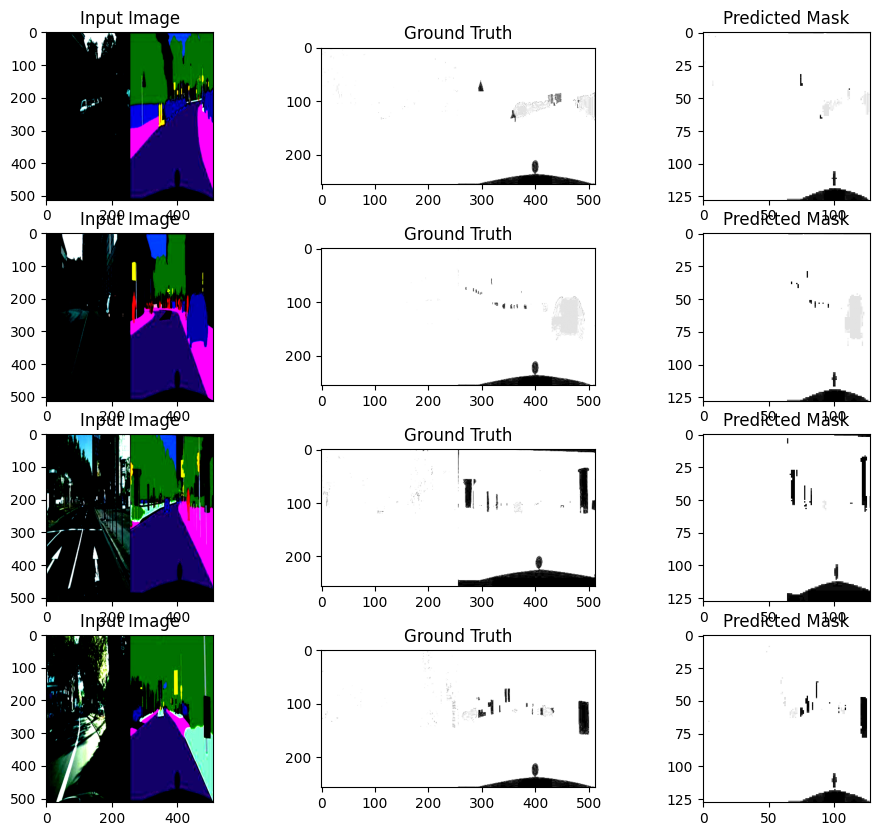

In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt

def visualize_predictions(model, val_loader, num_images=4):
    model.eval()
    images, masks = next(iter(val_loader))
    images, masks = images[:num_images].to(device), masks[:num_images].to(device)

# Evaluation block (no gradients needed during inference)
    with torch.no_grad():
        outputs = model(pixel_values=images).logits
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(12, 10))

    for i in range(num_images):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Input Image")
        axes[i, 1].imshow(masks[i], cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(preds[i], cmap="gray")
        axes[i, 2].set_title("Predicted Mask")

    plt.show()

visualize_predictions(model, val_loader)


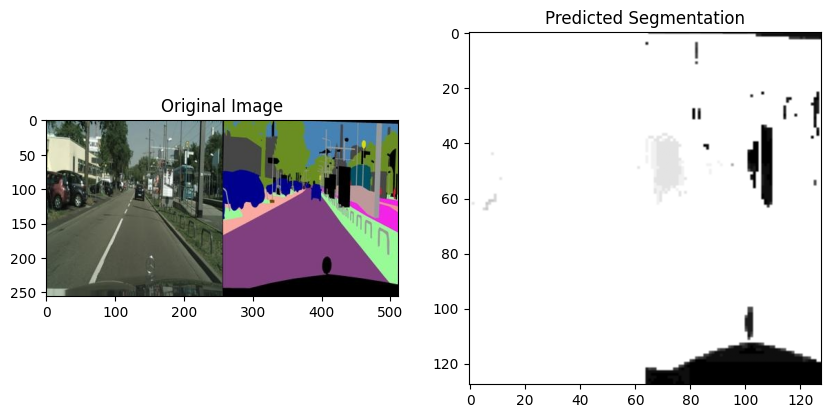

In [13]:
#test
# Import necessary libraries
import cv2
# Import necessary libraries
import numpy as np
# Import necessary libraries
import torch
image_path = ""
def predict_segmentation(model, processor, image_path):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    inputs = processor(image, return_tensors="pt").to("cuda")

# Evaluation block (no gradients needed during inference)
    with torch.no_grad():
        outputs = model(**inputs).logits
        preds = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(preds, cmap="gray")
    plt.title("Predicted Segmentation")
    plt.show()
predict_segmentation(model, processor, "/content/drive/My Drive/Colab_Notebooks/Cityscape transformer model/cityscapes_data/val/12.jpg")
